In [1]:
import argparse
import glob
import json
import os
from pathlib import Path

import numpy as np
import torch
import yaml
from tqdm import tqdm

from utils.google_utils import attempt_load
from utils.datasets import create_dataloader
from utils.general import coco80_to_coco91_class, check_dataset, check_file, check_img_size, box_iou, \
    non_max_suppression, scale_coords, xyxy2xywh, xywh2xyxy, clip_coords, set_logging, increment_path
from utils.loss import compute_loss
from utils.metrics import ap_per_class
from utils.plots import plot_images, output_to_target
from utils.torch_utils import select_device, time_synchronized
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from models.models import *
import warnings
warnings.filterwarnings('ignore')

/home/ayina/anaconda3/envs/cottonweed3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
parser = argparse.ArgumentParser(prog='test.py')
parser.add_argument('--weights', nargs='+', type=str, 
                    default='/home/ayina/MscThesis/DCW/YOLOv4/runs/train/yolov4_08/weights/best.pt')
parser.add_argument('--data', type=str, default='./data/test_coco.yaml', help='*.data path')
parser.add_argument('--batch-size', type=int, default=1, help='size of each image batch')
parser.add_argument('--img-size', type=int, default=640, help='inference size (pixels)')
parser.add_argument('--conf-thres', type=float, default=0.001, help='object confidence threshold')
parser.add_argument('--iou-thres', type=float, default=0.65, help='IOU threshold for NMS')
parser.add_argument('--task', default='499', help="'val', 'test', 'study'")
parser.add_argument('--device', default='0', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
parser.add_argument('--single-cls', action='store_true', help='treat as single-class dataset')
parser.add_argument('--augment', action='store_true', help='augmented inference')
parser.add_argument('--verbose', action='store_true', help='report mAP by class')
parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
parser.add_argument('--save-conf', action='store_true', help='save confidences in --save-txt labels')
parser.add_argument('--save-json', action='store_true', help='save a cocoapi-compatible JSON results file')
parser.add_argument('--project', default='runs/test', help='save to project/name')
parser.add_argument('--name', default='exp', help='save to project/name')
parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
parser.add_argument('--cfg', type=str, default='./cfg/yolov4.cfg', help='*.cfg path')
parser.add_argument('--names', type=str, default='./data/weed.names', help='*.cfg path')
opt = parser.parse_args("")

In [3]:
def load_classes(path):
    # Loads *.names file at 'path'
    with open(path, 'r') as f:
        names = f.read().split('\n')
    return list(filter(None, names))  # filter removes empty strings (such as last line)

cats = [
    "N/A",
    "Waterhemp",
    "MorningGlory",
    "Purslane",
    "SpottedSpurge",
    "Carpetweed",
    "Ragweed",
    "Eclipta",
    "PricklySida",
    "PalmerAmaranth",
    "Sicklepod",
    "Goosegrass",
    "CutleafGroundcherry"
]

In [4]:
def generate_mask(image_size, grid_size, prob_thresh):
    image_w, image_h = image_size
    grid_w, grid_h = grid_size
    cell_w, cell_h = math.ceil(image_w / grid_w), math.ceil(image_h / grid_h)
    up_w, up_h = (grid_w + 1) * cell_w, (grid_h + 1) * cell_h

    mask = (np.random.uniform(0, 1, size=(grid_h, grid_w)) <
            prob_thresh).astype(np.float32)
    mask = cv2.resize(mask, (up_w, up_h), interpolation=cv2.INTER_LINEAR)
    offset_w = np.random.randint(0, cell_w)
    offset_h = np.random.randint(0, cell_h)
    mask = mask[offset_h:offset_h + image_h, offset_w:offset_w + image_w]
    return mask

def mask_image(image, mask):
    masked = ((image.astype(np.float32) / 255 * np.dstack([mask] * 3)) * 255).astype(np.uint8)
    return masked

def iou(box1, box2):
    box1 = np.asarray(box1)
    box2 = np.asarray(box2)
    tl = np.vstack([box1[:2], box2[:2]]).max(axis=0)
    br = np.vstack([box1[2:], box2[2:]]).min(axis=0)
    intersection = np.prod(br - tl) * np.all(tl < br).astype(float)
    area1 = np.prod(box1[2:] - box1[:2])
    area2 = np.prod(box2[2:] - box2[:2])
    return intersection / (area1 + area2 - intersection)

In [19]:
def mask(data,
         weights=None,
         batch_size=8,
         imgsz=640,
         conf_thres=0.001,
         iou_thres=0.6,  # for NMS
         save_json=True,
         single_cls=False,
         augment=False,
         verbose=False,
         model=None,
         dataloader=None,
         save_dir=Path(''),  # for saving images
         save_txt=False,  # for auto-labelling
         save_conf=False,
         plots=True,
         log_imgs=0,
        max_size=640):  # number of logged images

    # Initialize/load model and set device
    training = model is not None
    if training:  # called by train.py
        device = next(model.parameters()).device  # get model device

    else:  # called directly
        #set_logging()
        device = select_device(opt.device, batch_size=batch_size)

        # Load model
        model = Darknet(opt.cfg).to(device)

        try:
            ckpt = torch.load(weights, map_location=device)  # load checkpoint
            ckpt['model'] = {k: v for k, v in ckpt['model'].items() if model.state_dict()[k].numel() == v.numel()}
            model.load_state_dict(ckpt['model'], strict=False)
        except:
            load_darknet_weights(model, weights[0])
        imgsz = check_img_size(imgsz, s=64)  # check img_size

    # Half
    half = device.type != 'cpu'  # half precision only supported on CUDA
    if half:
        model.half()

    # Configure
    model.eval()
    is_coco = data.endswith('coco.yaml')  # is COCO dataset
    with open(data) as f:
        data = yaml.load(f, Loader=yaml.FullLoader)  # model dict
    check_dataset(data)  # check
    nc = 1 if single_cls else int(data['nc'])  # number of classes
    iouv = torch.linspace(0.5, 0.95, 10).to(device)  # iou vector for mAP@0.5:0.95
    niou = iouv.numel()

    # Dataloader
    if not training:
        img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
        _ = model(img.half() if half else img) if device.type != 'cpu' else None  # run once
        path = data['test'] 
        dataloader = create_dataloader(path, imgsz, batch_size, 64, opt, pad=0.5, rect=True)[0]

    seen = 0
    try:
        names = model.names if hasattr(model, 'names') else model.module.names
    except:
        names = load_classes(opt.names)
    coco91class = coco80_to_coco91_class()
    
    ######################################################################
    
    for batch_i, (img, targets, paths, shapes) in enumerate(dataloader):
        path = Path(paths[0])

        file_name = f"{int(opt.task):012d}.jpg"
        src_path = "/home/ayina/MscThesis/DCW/datasets/Dataset_final/DATA_0_YOLO/images/"
        img_path = src_path + file_name
        
        if str(path) != img_path:
            continue
        
        print("path: ", img_path)
        nb, _, height, width = img.shape  # batch size, channels, height, width
        res = np.zeros((height, width), dtype=np.float32)
        whwh = torch.Tensor([width, height, width, height])
        
        image_targets = targets
        labels = image_targets[image_targets[:, 0] == 0, 1:]
        target_classes = image_targets[:, 1].numpy().astype('int')
        tbox = xywh2xyxy(labels[:, 1:5]) * whwh
        tbox = tbox.numpy()
        
        # set parameters for saliency map creation
        
        target_class_index = 5
        misclass = 5
        
        for j, box in enumerate(tbox):
            cat_id = int(target_classes[j])+1
            if cat_id == target_class_index:
                target_box = box
        
        target_box = target_box.astype(int)
        prob_thresh= 0.25
        grid_size= (16, 16)
        n_masks= 2000
        
        print("target_box ", target_box)
        
        # original image for plotting later
        
        if isinstance(img, torch.Tensor):
            image = img.cpu().float().numpy()
                
        if np.max(image[0]) <= 1:
            image *= 255
            
        image = image[0]
        image = image.transpose(1, 2, 0)
        
        
        # generate masked images
        
        if isinstance(img, torch.Tensor):
            image_np = img[0].float().numpy()
            image_np = image_np.transpose(1, 2, 0)
            
        for _ in range(n_masks):
            mask = generate_mask(image_size=(width, height),
                                 grid_size=grid_size,
                                 prob_thresh=prob_thresh)
            masked = mask_image(image_np, mask)

            # prepare masked image for inference

            masked = masked.transpose((2, 0, 1))
            masked = torch.from_numpy(masked)
            masked = masked.unsqueeze(0)
            masked = masked.to(device, non_blocking=True)
            masked = masked.half() if half else masked.float()
            masked /= 255.0
            
            # Run model
            with torch.no_grad():
                inf_out, train_out = model(masked, augment=augment)  # inference and training outputs
                output = non_max_suppression(inf_out, conf_thres=conf_thres, iou_thres=iou_thres)
                
            max_iou_score = 0
            
            for si, pred in enumerate(output):
                labels = targets[targets[:, 0] == si, 1:]
                nl = len(labels)
                tcls = labels[:, 0].tolist() if nl else []  # target class
                seen += 1

                box = pred[:, :4].clone()  # xyxy

                for p, b in zip(pred.tolist(), box.tolist()):
                    cat_id = coco91class[int(p[5])] if is_coco else int(p[5])
                    cat = cats[cat_id]
                    bbox = [int(x) for x in b]
                    bboxa = np.asarray(bbox)
                    score = round(p[4], 5)
                    
                    if cat_id == misclass:
                        #print("bbox: ", bbox)
                        iou_score = iou(target_box, bbox) * score
                        if iou_score > max_iou_score:
                            max_iou_score = iou_score 
                        
                res += mask * max_iou_score

        fig = plt.figure(figsize=(6, 4))
        fig.add_subplot()
        ax = plt.gca()
        ax.imshow(image.astype('uint8'))
        ax.add_patch(plt.Rectangle((target_box[0], target_box[1]), target_box[2] - target_box[0], 
                                   target_box[3] - target_box[1],
                                        fill=False, color='white', linewidth=2))
        ax.imshow(res, cmap='jet', alpha=0.4)
            
        plt.axis('off')
        plt.show()
        break

image 681

Scanning labels /home/ayina/MscThesis/DCW/datasets/Dataset_final/DATA_0_YOLO/labels.cache3 (848 found, 0 missing, 0 empty, 0 duplicate, for 848 images): 848it [00:00, 28881.61it/s]


path:  /home/ayina/MscThesis/DCW/datasets/Dataset_final/DATA_0_YOLO/images/000000000681.jpg
target_box  [131 352 150 372]


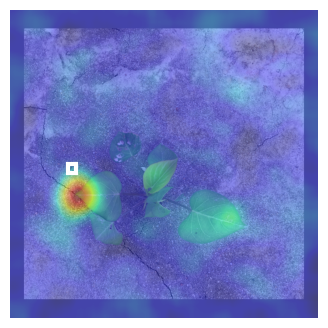

In [20]:
np.random.seed(0)
mask(opt.data,
         opt.weights,
         opt.batch_size,
         opt.img_size,
         opt.conf_thres,
         opt.iou_thres,
         opt.save_json,
         opt.single_cls,
         opt.augment,
         opt.verbose,
         save_txt=opt.save_txt,
         save_conf=opt.save_conf,
         )

image 654

Scanning labels /home/ayina/MscThesis/DCW/datasets/Dataset_final/DATA_0_YOLO/labels.cache3 (848 found, 0 missing, 0 empty, 0 duplicate, for 848 images): 848it [00:00, 14943.85it/s]


path:  /home/ayina/MscThesis/DCW/datasets/Dataset_final/DATA_0_YOLO/images/000000000654.jpg
target_box  [208 615 220 630]


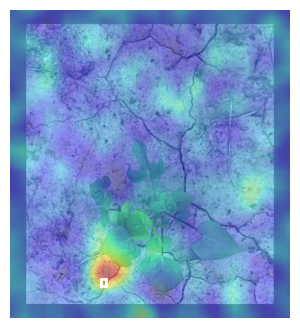

In [6]:
np.random.seed(0)
mask(opt.data,
         opt.weights,
         opt.batch_size,
         opt.img_size,
         opt.conf_thres,
         opt.iou_thres,
         opt.save_json,
         opt.single_cls,
         opt.augment,
         opt.verbose,
         save_txt=opt.save_txt,
         save_conf=opt.save_conf,
         )

Scanning labels /home/ayina/MscThesis/DCW/datasets/Dataset_final/DATA_0_YOLO/labels.cache3 (848 found, 0 missing, 0 empty, 0 duplicate, for 848 images): 848it [00:00, 28627.99it/s]


path:  /home/ayina/MscThesis/DCW/datasets/Dataset_final/DATA_0_YOLO/images/000000000600.jpg
target_box  [114 184 607 657]


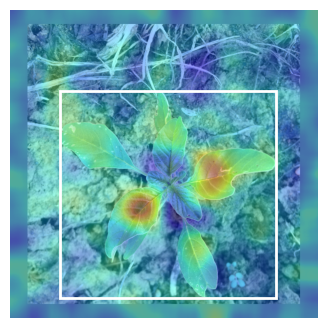

In [17]:
np.random.seed(0)
mask(opt.data,
         opt.weights,
         opt.batch_size,
         opt.img_size,
         opt.conf_thres,
         opt.iou_thres,
         opt.save_json,
         opt.single_cls,
         opt.augment,
         opt.verbose,
         save_txt=opt.save_txt,
         save_conf=opt.save_conf,
         )

Scanning labels /home/ayina/MscThesis/DCW/datasets/Dataset_final/DATA_0_YOLO/labels.cache3 (848 found, 0 missing, 0 empty, 0 duplicate, for 848 images): 848it [00:00, 28012.46it/s]


path:  /home/ayina/MscThesis/DCW/datasets/Dataset_final/DATA_0_YOLO/images/000000000499.jpg
target_box  [522 449 545 477]


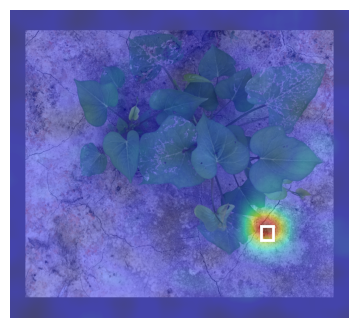

In [20]:
np.random.seed(0)
mask(opt.data,
         opt.weights,
         opt.batch_size,
         opt.img_size,
         opt.conf_thres,
         opt.iou_thres,
         opt.save_json,
         opt.single_cls,
         opt.augment,
         opt.verbose,
         save_txt=opt.save_txt,
         save_conf=opt.save_conf,
         )